In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [8]:
train_data = pd.read_csv('train.txt', header=None, sep=';', names=['Comment','Emotion'], encoding='utf-8')

In [9]:
train_data.sample(5)

,Comment,Emotion
9783,im not crossing things off ever growing to do ...,sadness
13931,i was feeling really emotionally distraught an...,fear
2048,i do struggle i dont get anxious instead i fee...,joy
15227,i was in the bathroom i had sat down to pee it...,sadness
11512,i ask you not to feel pressured by this,fear


In [10]:
train_data.shape

(16000, 2)

In [11]:
train_data.isnull().sum()

Comment    0
Emotion    0
dtype: int64

In [12]:
train_data.duplicated().sum()

1

In [13]:
train_data['length'] = [len(x) for x in train_data['Comment']]

In [14]:
train_data.head(3)

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48


In [15]:
train_data.drop_duplicates(inplace=True)

In [16]:
train_data['Emotion'].value_counts()

joy         5361
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

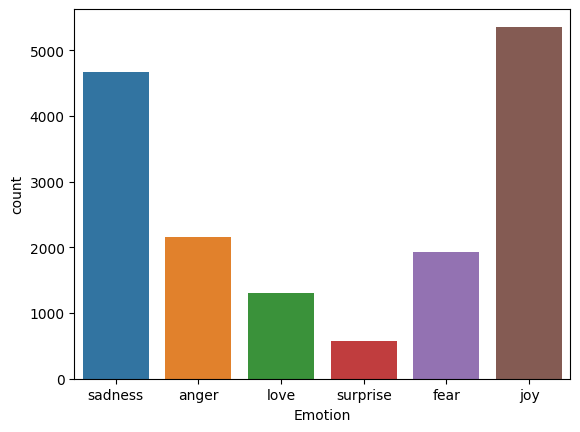

In [17]:
sns.countplot(x=train_data['Emotion'])
plt.show()

In [18]:
df2 = train_data.copy()

In [19]:
length_values = df2['length'].values

In [20]:
length_values

array([ 23, 108,  48, ...,  30,  59,  62])

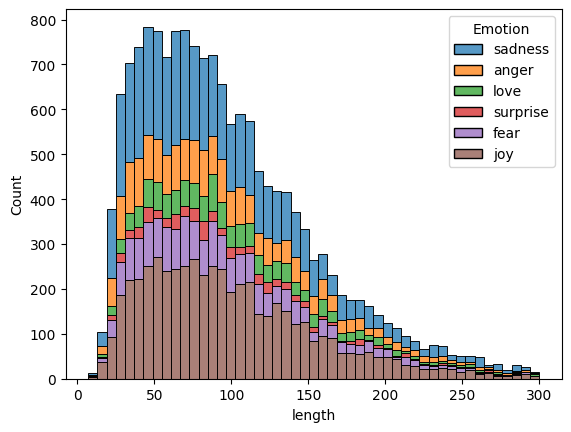

In [21]:
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')
plt.show()

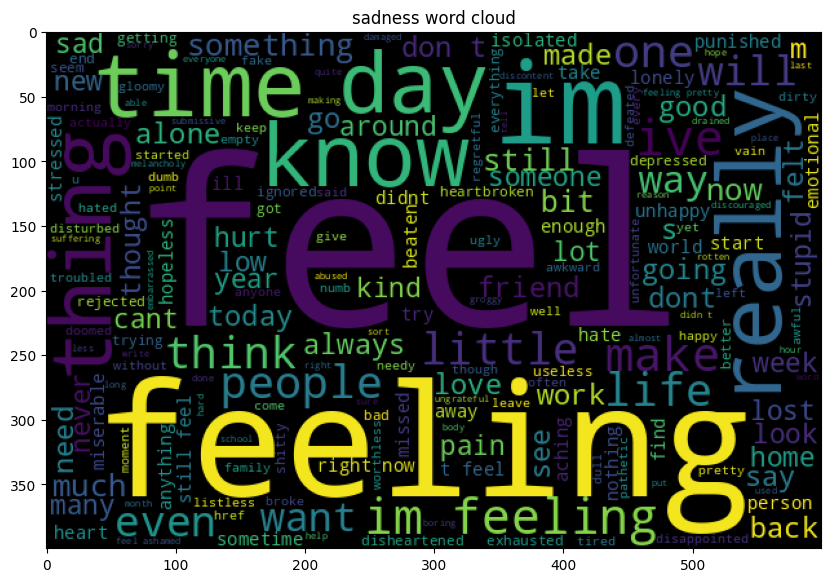

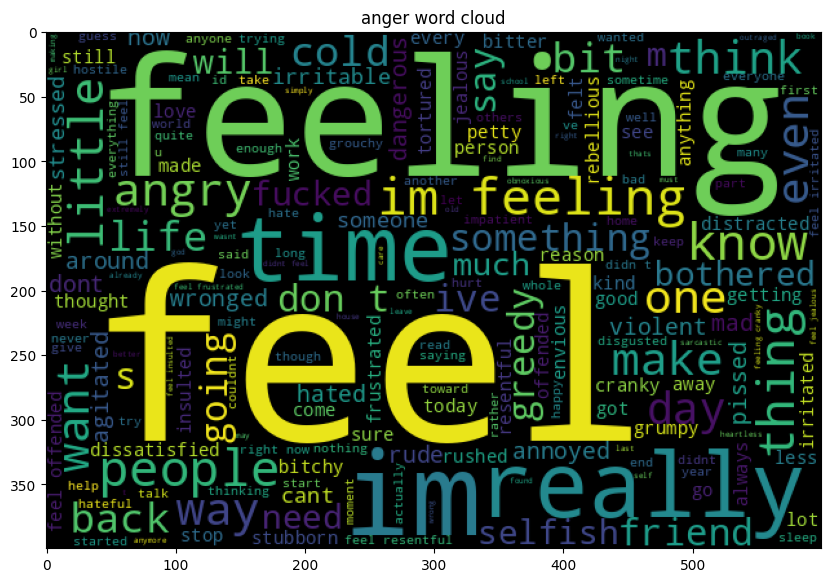

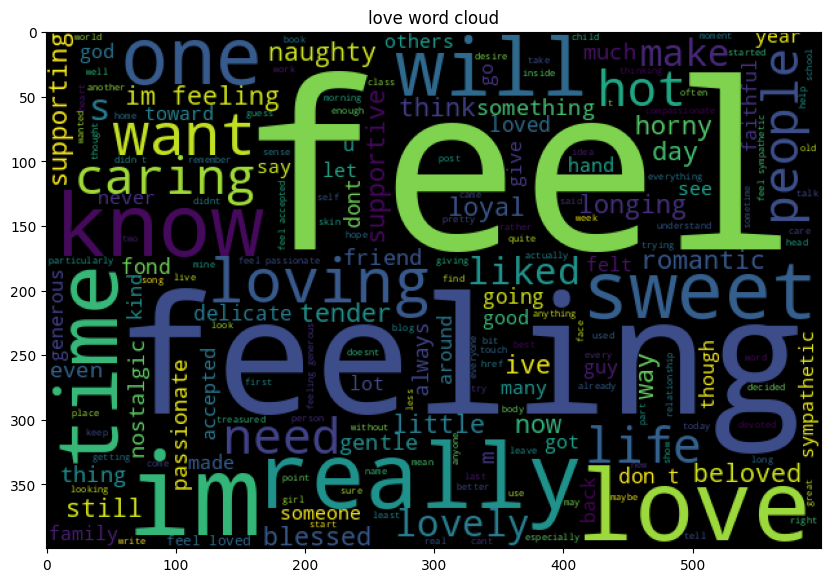

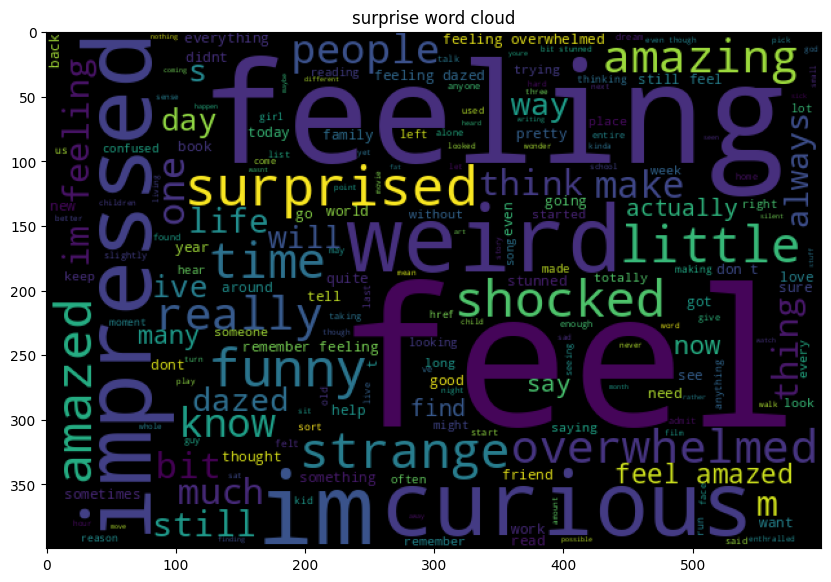

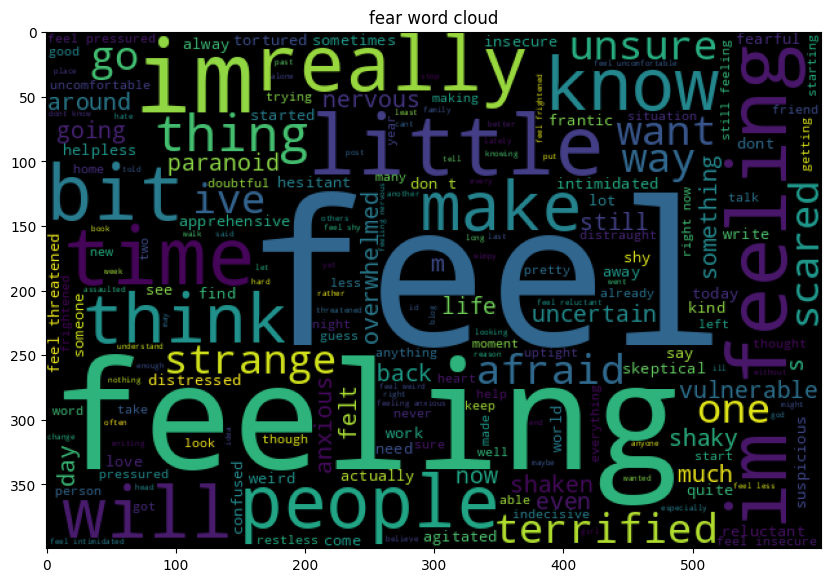

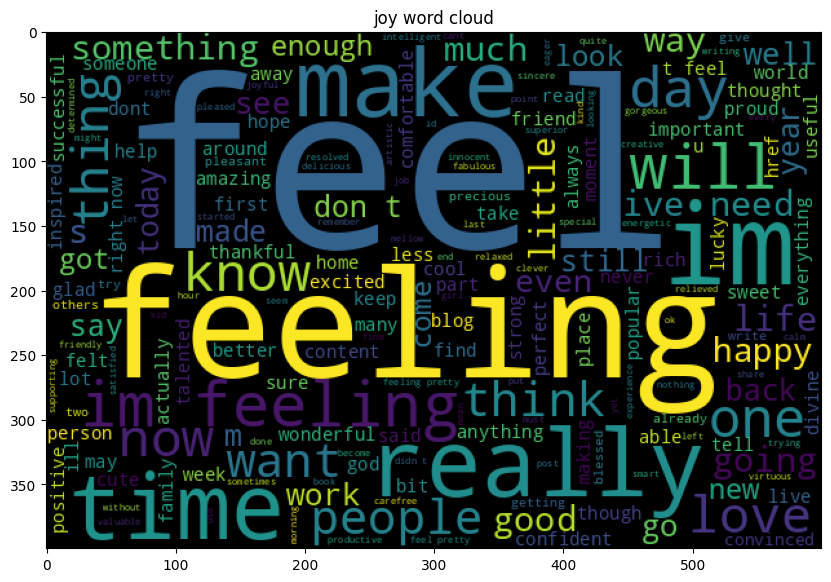

In [22]:
def words_cloud(wordcloud, emotion):
    plt.figure(figsize=(10,10))
    plt.title(emotion+' word cloud')    
    plt.imshow(wordcloud)

emotions_list = train_data['Emotion'].unique()

for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion']==emotion, 'Comment']])    
    wordcloud = WordCloud(width=600, height=400).generate(text)
    words_cloud(wordcloud, emotion)

In [23]:
lb = LabelEncoder()
train_data['Emotion_Encoded'] = lb.fit_transform(train_data['Emotion'])

In [24]:
train_data.head(5)

,Comment,Emotion,length,Emotion_Encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0


# Applying Machine Learning

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [26]:
df = train_data.copy()

In [27]:
df.head()

,Comment,Emotion,length,Emotion_Encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0


In [28]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text)


[nltk_data] Downloading package stopwords to /home/lenovo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
df.head(5)

,Comment,Emotion,length,Emotion_Encoded,cleaned_comment
0,i didnt feel humiliated,sadness,23,4,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,108,4,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,48,0,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,92,3,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,20,0,feel grouchi


In [30]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'], df['Emotion_Encoded'],
                                                    test_size=0.2, random_state=42)

In [31]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [32]:
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\nAccuracy using TF-IDF: {accuracy_tfidf}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tfidf))


===== Multinomial Naive Bayes =====

Accuracy using TF-IDF: 0.6590625
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.32      0.48       439
           1       0.88      0.23      0.37       375
           2       0.58      0.98      0.73      1027
           3       1.00      0.03      0.05       303
           4       0.72      0.91      0.80       950
           5       1.00      0.02      0.04       106

    accuracy                           0.66      3200
   macro avg       0.85      0.42      0.41      3200
weighted avg       0.76      0.66      0.59      3200


===== Logistic Regression =====

Accuracy using TF-IDF: 0.8240625
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       439
           1       0.85      0.72      0.78       375
           2       0.76      0.94      0.84      1027
           3       0.83      0.46      0.59       303
  

In [33]:
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
y_pred_lg = lg.predict(X_test_tfidf)

In [34]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label =  np.max(lg.predict(input_vectorized))

    return predicted_emotion,label

# Example usage 
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Label :",label)
    print("================================================================")


i didnt feel humiliated
Prediction : sadness
Label : 4
i feel strong and good overall
Prediction : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Label : 0
He was speechles when he found out he was accepted to this new job
Prediction : joy
Label : 2
This is outrageous, how can you talk like that?
Prediction : anger
Label : 0
I feel like im all alone in this world
Prediction : sadness
Label : 4
He is really sweet and caring
Prediction : love
Label : 3
You made me very crazy
Prediction : sadness
Label : 4
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Label : 3
i am feeling grouchy
Prediction : anger
Label : 0
He hates you
Prediction : anger
Label : 0


In [35]:
# save files
import pickle
pickle.dump(lg,open("logistic_regresion.pkl",'wb'))
pickle.dump(lb,open("label_encoder.pkl",'wb'))
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl",'wb'))


# Applying Deep learning Using LSTM

In [36]:
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding


In [37]:
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)


In [38]:
y_train = to_categorical(train_data["Emotion_Encoded"])

In [39]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=4, batch_size=64, verbose=1, callbacks=[callback])


Epoch 1/4
250/250 [==============================] - 90s 351ms/step - loss: 1.6453 - accuracy: 0.3191
Epoch 2/4
250/250 [==============================] - 100s 401ms/step - loss: 1.3061 - accuracy: 0.5217
Epoch 3/4
250/250 [==============================] - 105s 419ms/step - loss: 0.7526 - accuracy: 0.7180
Epoch 4/4
250/250 [==============================] - 110s 440ms/step - loss: 0.5153 - accuracy: 0.8225


In [41]:
def pred(text):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad


sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = pred(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")


i feel strong and good overall
1/1 [==============================] - 0s 36ms/step
joy : 0.9795820713043213


im grabbing a minute to post i feel greedy wrong
1/1 [==============================] - 0s 34ms/step
anger : 0.899980366230011


He was speechles when he found out he was accepted to this new job
1/1 [==============================] - 0s 36ms/step
joy : 0.9063654541969299


This is outrageous, how can you talk like that?
1/1 [==============================] - 0s 36ms/step
anger : 0.5960159301757812


I feel like im all alone in this world
1/1 [==============================] - 0s 36ms/step
sadness : 0.7576930522918701


He is really sweet and caring
1/1 [==============================] - 0s 35ms/step
joy : 0.5382832884788513


You made me very crazy
1/1 [==============================] - 0s 35ms/step
joy : 0.8667007684707642


i am ever feeling nostalgic about the fireplace i will know that it is still on the property
1/1 [==============================] - 0s 34ms/step
love : 0

In [42]:
model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)
